#Feature extraction

##Written by Gergana Slaveykova s1070004
##Radboud University- B3 Thesis project

#Imports

In [ ]:
#Mount Google Drive to acess data and storing purposes
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Download the VGG Face model archive from the specified URL
! wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
# Extract the contents of the downloaded tar.gz archive
! tar -xvf vgg_face_torch.tar.gz
# Install the torchfile Python package, which is used for reading Torch7 files
! pip install torchfile


In [ ]:
#Imports
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchfile
from PIL import Image
from scipy import signal

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt


#VGG16 network- source Thirza Dado

In [ ]:

class VGG_16(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the number of convolutional layers in each block
        self.block_size = [2, 2, 3, 3, 3]
        # Define the convolutional layers
        self.conv_1_1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv_2_1 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv_3_1 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_3_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv_4_1 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv_4_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_4_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv_5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        # Define the fully connected layers
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 2622)

    def load_weights(self, path="/content/vgg_face_torch/VGG_FACE.t7"):
       # Load the pre-trained weights from a Torch7 file
        model = torchfile.load(path)
        counter = 1
        block = 1
        # Iterate over the layers in the pre-trained model
        for i, layer in enumerate(model.modules):
            if layer.weight is not None:
                if block <= 5:
                    # Load weights and biases for convolutional layers
                    self_layer = getattr(self, "conv_%d_%d" % (block, counter))
                    counter += 1
                    if counter > self.block_size[block - 1]:
                        counter = 1
                        block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]
                else:
                    # Load weights and biases for fully connected layers
                    self_layer = getattr(self, "fc%d" % (block))
                    block += 1
                    self_layer.weight.data[...] = torch.tensor(layer.weight).view_as(self_layer.weight)[...]
                    self_layer.bias.data[...] = torch.tensor(layer.bias).view_as(self_layer.bias)[...]

    def forward(self, x, layer):
        """ Pytorch forward
        Args:
            x: input image (224x224)
        Returns: class logits
        """
        x = F.relu(self.conv_1_1(x))
        x = F.relu(self.conv_1_2(x))
        x = F.max_pool2d(x, 2, 2)
        if layer == 1:
            return x
        x = F.relu(self.conv_2_1(x))
        x = F.relu(self.conv_2_2(x))
        x = F.max_pool2d(x, 2, 2)
        if layer == 2:
            return x
        x = F.relu(self.conv_3_1(x))
        x = F.relu(self.conv_3_2(x))
        x = F.relu(self.conv_3_3(x))
        x = F.max_pool2d(x, 2, 2)
        if layer == 3:
            return x
        x = F.relu(self.conv_4_1(x))
        x = F.relu(self.conv_4_2(x))
        x = F.relu(self.conv_4_3(x))
        x = F.max_pool2d(x, 2, 2)
        if layer == 4:
            return x
        x = F.relu(self.conv_5_1(x))
        x = F.relu(self.conv_5_2(x))
        x = F.relu(self.conv_5_3(x))
        x = F.max_pool2d(x, 2, 2)
        if layer == 5:
            return x
        # Fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc6(x))
        x = F.dropout(x, 0.5, self.training)
        # if layer == 6:
        #     return x
        # x = F.relu(self.fc7(x))
        # x = F.dropout(x, 0.5, self.training)
        # if layer == 7:
        #     return x
        # return self.fc8(x)




In [ ]:
def kernel(n):
    # Create a 2D meshgrid of size n x n with values ranging from -1 to 1
    x, y = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
    # Compute the distance from the origin for each point in the grid
    dst = np.sqrt(x*x + y*y)
    # Define Gaussian kernel parameters
    sigma = 1
    muu = 0.000
    # Compute the Gaussian kernel
    return np.exp(-((dst-muu) ** 2 / ( 2.0 * sigma**2)))


def downsample(filters, layer):
    # Define the downsampled dimensions for each layer
    ds = [56, 28]
    # Initialize an array to hold the downsampled filters
    result = np.zeros((filters.shape[1], ds[layer], ds[layer]))
    # Iterate over each filter
    for filter in range(filters.shape[1]):
        # Convolve the filter with a Gaussian kernel and downsample by taking every second element
        result[filter] = signal.convolve(filters[0, filter], kernel(2), mode="same")[::2, ::2]
    # Return the downsampled filters with an extra dimension added
    return result[None]



In [ ]:
# StyleGAN-XL (natural images)
# VGG16 for object recognition

class Model:
    def __init__(self, model, weights):
        # Load the pre-trained model from PyTorch Hub with the specified weights
        self.model = torch.hub.load('pytorch/vision:v0.10.0', model, weights=weights).eval().to('cpu')
        # Define the preprocessing steps: resize, convert to tensor, and normalize
        self.preprocess = transforms.Compose([
            transforms.Resize(224), # Resize image to 224x224
            transforms.ToTensor(), # Convert image to PyTorch tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet mean and std
        ])

    def get_features(self, index, layer, folder, split, n, start=0):
        """
        Extract features from a specific layer of the model for a batch of images.

        Args:
            index (int): Index to decide downsampling.
            layer (int): The layer number to extract features from.
            folder (str): The folder name to load images from ('test' or other).
            split (int): Number of images per split.
            n (int): The split index.
            start (int, optional): Starting index for image loading. Defaults to 0.

        Returns:
            np.array: Extracted features.
        """
        output = []
        # Iterate over the images in the specified range
        for i in range(split * n, split * (n + 1)):
            # Load the image based on folder and index
            if folder=="test":
              input_image = Image.open("/content/drive/MyDrive/GOD-NEW-3p/Reversed_Combining/All_regions/PPA/image_%d.png" % (i))
            else:
              input_image = Image.open("/content/drive/My Drive/Thesis/%s/train_face_%d.png" % (folder, i))
            # Preprocess the image
            input_tensor = self.preprocess(input_image).unsqueeze(0).to('cpu')
            # Extract features from the specified layer
            _out = self.model.features[:layer](input_tensor).detach().numpy()
            # Downsample the output if necessary
            if index < 2:
                _out = downsample(_out, index)
            # Append the features to the output list
            output.append(_out)
        return np.array(output).squeeze()






In [ ]:
# VGG16 for object recognition
vgg = Model("vgg16", "VGG16_Weights.DEFAULT")
layers = [5, 10, 17, 24, 31]
split = 50

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


#The extraction for text and train

In [ ]:
# test set features
import os
vgg_t1 = np.zeros((50, 64, 56, 56))  # ds: 112 -> 56
vgg_t2 = np.zeros((50, 128, 28, 28)) # ds: 56 -> 28
vgg_t3 = np.zeros((50, 256, 28, 28))
vgg_t4 = np.zeros((50, 512, 14, 14))
vgg_t5 = np.zeros((50, 512, 7, 7))
vgg_test  = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]


# Define the directory path
dir_path = "/content/drive/MyDrive/reversed_mine_features/"

# Create the directory if it does not exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

for i, layer in enumerate(layers):
    print(i)
    for n in range(1):
        vgg_test[i][n*split:(n+1)*split] = vgg.get_features(i, layer, "test", split=split, n=n)
    # Save the numpy array
    np.save(os.path.join(dir_path, "Reversed_PPA_features_vgg_te_%i.npy" % i), vgg_test[i])

print("ready")

In [ ]:
# Training set features
# vgg_t1 = np.zeros((1050, 64, 56, 56))
# vgg_t2 = np.zeros((1050, 128, 28, 28))
# vgg_t3 = np.zeros((1050, 256, 28, 28))
# vgg_t4 = np.zeros((1050, 512, 14, 14))
# vgg_t5 = np.zeros((1050, 512, 7, 7))

# split = 50

# vgg_train = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]
# for i, layer in enumerate(layers):
#   print(f"I am currently layer {layer}")
#   for n in range(21):
#       vgg_train[i][n*split:(n+1)*split] = vgg.get_features(i, layer, "train", split=split, n=n)
#   np.save("/content/drive/My Drive/VGG16/objects_features_vgg_tr_%i.npy" % i, vgg_train[i])



# Perseptual similatity

In [ ]:
# Define the number of layers
num_layers = 5

# File paths for new test features
test_file_paths = [f'/content/drive/MyDrive/isolation_features_filtered/V1_features_vgg_te_{i}.npy' for i in range(0, num_layers + 1)]

# Load the original test features
test_features = []

for i in range(num_layers):
    features = np.load(test_file_paths[i]).reshape(50, -1).squeeze()
    test_features.append(features)
    print(f"Layer {i + 1} - Test features reconstructions: {features.shape}")


# File paths for old dataset features
new_test_file_paths = [f'/content/drive/My Drive/newDataExperimentationGOD/objects_features_vgg_te_{i}.npy' for i in range(0, num_layers + 1)]

# Load the new dataset features
new_test_features = []
for i in range(num_layers):
    features = np.load(new_test_file_paths[i]).reshape(50, -1).squeeze()
    new_test_features.append(features)
    print(f"Layer {i + 1} - Old test features: {features.shape}")

# Compute cosine similarity for each layer
cosine_similarities = []
for i in range(num_layers):
    cosine_sim = cosine_similarity(test_features[i], new_test_features[i])
    cosine_similarities.append(cosine_sim)
    print(f"Layer {i + 1} - Cosine Similarity:\n{cosine_sim}")

# Analyze or aggregate the cosine similarity results as needed
# For example, you might want to average the similarities for each layer
average_similarities = [np.mean(cosine_sim) for cosine_sim in cosine_similarities]
std_similarities = [np.std(cosine_sim) for cosine_sim in cosine_similarities]

for i, (avg_sim, std_sim) in enumerate(zip(average_similarities, std_similarities)):
    print(f"Layer {i + 1} - Average Cosine Similarity: {avg_sim}, Standard Deviation: {std_sim}")


## This was not the best way but the results were manually transfered to the tables bellow.

#the progressive addition- perceptual similarity

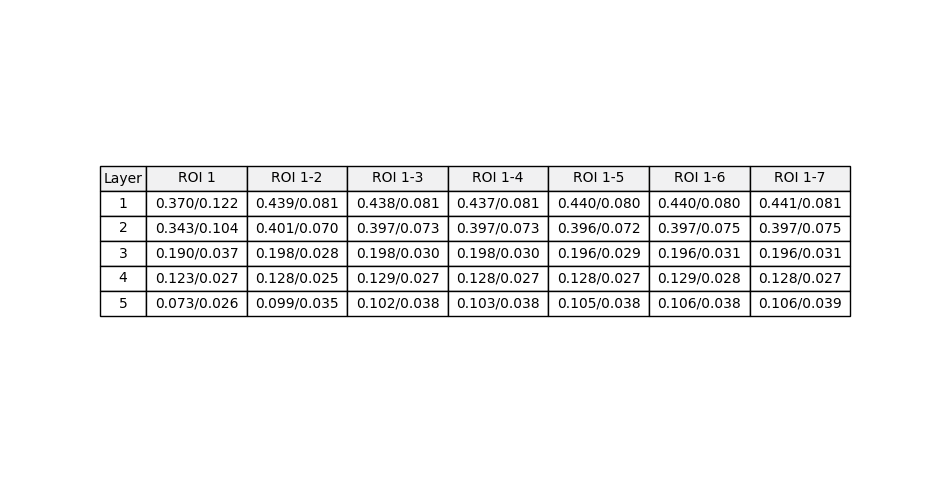

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data provided with formatted values to three decimal places
data = {
    "Layer": [1, 2, 3, 4, 5],
    "ROI 1": [
        "0.370/0.122", "0.343/0.104", "0.190/0.037", "0.123/0.027", "0.073/0.026"
    ],
    "ROI 1-2": [
        "0.439/0.081", "0.401/0.070", "0.198/0.028", "0.128/0.025", "0.099/0.035"
    ],
    "ROI 1-3": [
        "0.438/0.081", "0.397/0.073", "0.198/0.030", "0.129/0.027", "0.102/0.038"
    ],
    "ROI 1-4": [
        "0.437/0.081", "0.397/0.073", "0.198/0.030", "0.128/0.027", "0.103/0.038"
    ],
    "ROI 1-5": [
        "0.440/0.080", "0.396/0.072", "0.196/0.029", "0.128/0.027", "0.105/0.038"
    ],
    "ROI 1-6": [
        "0.440/0.080", "0.397/0.075", "0.196/0.031", "0.129/0.028", "0.106/0.038"
    ],
    "ROI 1-7": [
        "0.441/0.081", "0.397/0.075", "0.196/0.031", "0.128/0.027", "0.106/0.039"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Reorder the columns to have "ROI 1" on the right
df = df[["Layer", "ROI 1","ROI 1-2", "ROI 1-3", "ROI 1-4", "ROI 1-5", "ROI 1-6", "ROI 1-7"]]

# Setting the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the table
ax = plt.gca()
ax.axis('tight')
ax.axis('off')

#plt.title('Isolation', fontsize=14)

# Drawing the table
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#f1f1f2"]*len(df.columns))

# Adding a frame
tbl.scale(1, 1.5)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(df.columns))))

plt.savefig('additive_way.png', bbox_inches='tight')
# Displaying the table
plt.show()


#Reversed

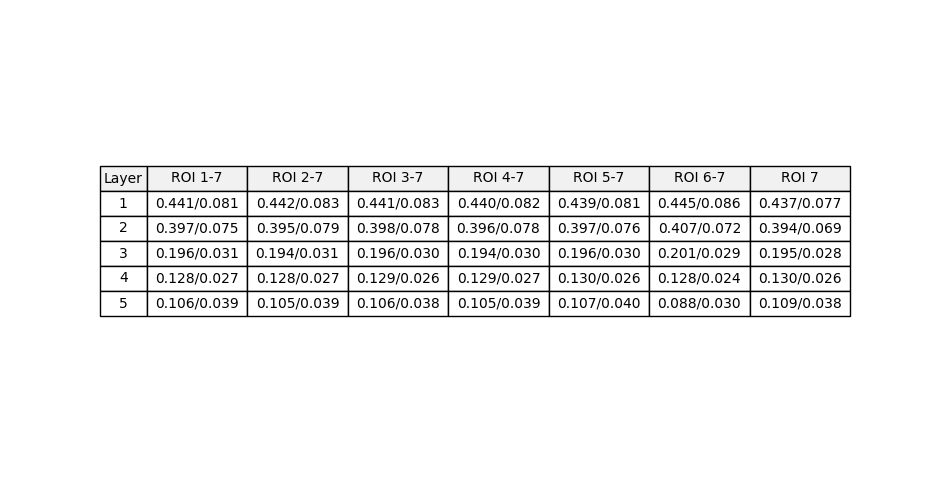

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data provided with formatted values to three decimal places
data = {
    "Layer": [1, 2, 3, 4, 5],
    "ROI 7": [
        "0.437/0.077", "0.394/0.069", "0.195/0.028", "0.130/0.026", "0.109/0.038"
    ],
    "ROI 6-7": [
        "0.445/0.086", "0.407/0.072", "0.201/0.029", "0.128/0.024", "0.088/0.030"
    ],
    "ROI 5-7": [
        "0.439/0.081", "0.397/0.076", "0.196/0.030", "0.130/0.026", "0.107/0.040"
    ],
    "ROI 4-7": [
        "0.440/0.082", "0.396/0.078", "0.194/0.030", "0.129/0.027", "0.105/0.039"
    ],
    "ROI 3-7": [
        "0.441/0.083", "0.398/0.078", "0.196/0.030", "0.129/0.026", "0.106/0.038"
    ],
    "ROI 2-7": [
        "0.442/0.083", "0.395/0.079", "0.194/0.031", "0.128/0.027", "0.105/0.039"
    ],
    "ROI 1-7": [
        "0.441/0.081", "0.397/0.075", "0.196/0.031", "0.128/0.027", "0.106/0.039"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Reorder the columns to have "ROI 7" on the right
df = df[["Layer", "ROI 1-7", "ROI 2-7", "ROI 3-7", "ROI 4-7", "ROI 5-7", "ROI 6-7", "ROI 7"]]

# Setting the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the table
ax = plt.gca()
ax.axis('tight')
ax.axis('off')

# Drawing the table
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#f1f1f2"]*len(df.columns))

# Adding a frame
tbl.scale(1, 1.5)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(df.columns))))

plt.savefig('additive_way.png', bbox_inches='tight')
# Displaying the table
plt.show()


#For isolation results

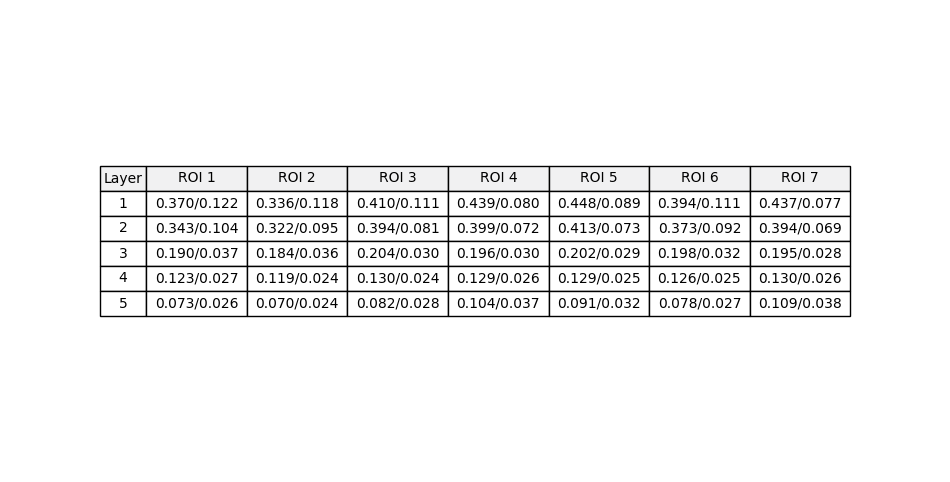

In [ ]:
#For isolation results

data = {
    "Layer": [1, 2, 3, 4, 5],
    "ROI 1": ["0.370/0.122", "0.343/0.104", "0.190/0.037", "0.123/0.027", "0.073/0.026"],
    "ROI 2": ["0.336/0.118", "0.322/0.095", "0.184/0.036", "0.119/0.024", "0.070/0.024"],
    "ROI 3": ["0.410/0.111", "0.394/0.081", "0.204/0.030", "0.130/0.024", "0.082/0.028"],
    "ROI 4": ["0.439/0.080", "0.399/0.072", "0.196/0.030", "0.129/0.026", "0.104/0.037"],
    "ROI 5": ["0.448/0.089", "0.413/0.073", "0.202/0.029", "0.129/0.025", "0.091/0.032"],
    "ROI 6": ["0.394/0.111", "0.373/0.092", "0.198/0.032", "0.126/0.025", "0.078/0.027"],
    "ROI 7": ["0.437/0.077", "0.394/0.069", "0.195/0.028", "0.130/0.026", "0.109/0.038"]
}

# Create DataFrame
df = pd.DataFrame(data)

# Setting the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the table
ax = plt.gca()
ax.axis('tight')
ax.axis('off')

#plt.title('Isolation', fontsize=14)

# Drawing the table
tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colColours=["#f1f1f2"]*len(df.columns))

# Adding a frame
tbl.scale(1, 1.5)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(df.columns))))

# Displaying the table
plt.savefig('isolation.png', bbox_inches='tight')
# Displaying the table
plt.show()
